# Triage Issue

* This is a helper notebook to go with the triage module
* It can be used to triage issues.
* Issues needing Triage are added to [Needs Triage Project](https://github.com/orgs/kubeflow/projects/26)

In [63]:
import matplotlib
import importlib
import logging
import sys
import os
import datetime
from dateutil import parser as dateutil_parser
import glob
import json
import numpy as np
import pandas as pd
# A bit of a hack to set the path correctly
sys.path = [os.path.abspath(os.path.join(os.getcwd(), ".."))] + sys.path

logging.basicConfig(level=logging.INFO,
                  format=('%(levelname)s|%(asctime)s'
                        '|%(message)s|%(pathname)s|%(lineno)d|'),
                datefmt='%Y-%m-%dT%H:%M:%S',
                )
logging.getLogger.setLevel(logging.INFO)

In [65]:
%matplotlib inline

In [217]:
import code_intelligence
from code_intelligence import graphql
from code_intelligence import triage
importlib.reload(triage)

<module 'code_intelligence.triage' from '/home/jlewi/git_code-intelligence/py/code_intelligence/triage.py'>

In [18]:
client = graphql.GraphQLClient()

## Download Issues

* Download the most recent issues

In [150]:
today = datetime.datetime.now()
today = datetime.datetime(year=today.year, month=today.month, day=today.day)

start_time = today - datetime.timedelta(weeks=24)

In [98]:
issue_filter = {
    "since": start_time.isoformat(),
}
start_time_day =  start_time.strftime("%Y%m%d")
repo = "kubeflow/kubeflow"
issues_dir = os.path.join(os.getcwd(), ".data", "issues", repo, start_time_day)

if os.path.exists(issues_dir):
    logging.info("Issues data already exists; not redownloading")
else:    
    triager = triage.IssueTriage()
    try:        
        triager.download_issues(repo, issues_dir)
    except Exception as download_error:
        raise

## Compute Triage Stats

In [218]:
shard_files = glob.glob(os.path.join(issues_dir, "*.json"))

def init_df(offset=0, size=300):
    """Initialize a dataframe of the specified size."""
    return pd.DataFrame({
        "time": [datetime.datetime.now()] * size,
        "delta": np.zeros(size),
    }, index=offset + np.arange(size))


def init_issue_df(offset=0, size=300):
    return pd.DataFrame({
        "created_at": [datetime.datetime(year=2050, month=1, day=1)] * size,
        "triaged_at": [datetime.datetime(year=2050, month=1, day=1)] * size,
        "closed": [bool] * size,
        "url": [""] * size,
        "needs_triage": [bool] * size,
    }, index=offset + np.arange(size))
    
    
def grow_df(df, offset=0, size=300):
    return pd.concat([df, init_df(offset, size)])

num_issues = 0

triage_stats = init_df(size=len(shard_files) * 100 * 2)
issues_df = init_issue_df(size=len(shard_files) * 100)

issues_index = 0

for f in shard_files:
    logging.info("Processing %s", f)
    with open(f) as hf:
        issues = json.load(hf)

    delta = 2 * len(issues)
    if num_issues + delta  > triage_stats.shape[0]:
        # Grow the dataframe
        triage_stats = grow_df(triage_stats, offset=triage_stats.shape[0], size=delta)

    
    if issues_index + len(issues) > issues_df.shape[0]:
        issues_df = grow_df(issues_df, offset= issues_df.shape[0], size=len(issues))    

    for i in issues:        
        info = triage.TriageInfo.from_issue(i)
        
        create_time = dateutil_parser.parse(info.issue["createdAt"])
        
        issues_df["created_at"].at[issues_index] = create_time
        issues_df["url"].at[issues_index] = info.issue["url"]
        issues_df["needs_triage"].at[issues_index] = info.needs_triage
        
        if not info.needs_triage and not info.triaged_at:
            raise ValueError("Issue doesn't need triage but triaged at time not set")
        if info.triaged_at:
            issues_df["triaged_at"].at[issues_index] = info.triaged_at            

        if info.closed_at:
            issues_df["closed"].at[issues_index] = True
        else:
            issues_df["closed"].at[issues_index] = False
        issues_index += 1


issues_df = issues_df[:issues_index]

In [219]:
# Filter issues to issues created after start_time
indexes = issues_df["created_at"] > start_time
issues_df = issues_df.iloc[indexes.values]

* Compute a series containing the number of untriaged issues as a function of time

In [220]:
opened = pd.Series([1]*issues_df.shape[0], index=issues_df["created_at"])
triaged_issues = issues_df.iloc[(issues_df["needs_triage"] == False).values]
triaged = pd.Series([-1]*triaged_issues.shape[0], index=triaged_issues["triaged_at"])

deltas = pd.concat([opened, triaged])
deltas = deltas.sort_index()
untriaged = deltas.cumsum()

In [221]:
untriaged

2019-02-15 00:10:37      1
2019-02-15 11:44:19      2
2019-02-15 19:08:13      3
2019-02-15 20:57:10      4
2019-02-15 21:30:48      5
                      ... 
2019-08-01 21:03:36    176
2019-08-01 21:28:25    177
2019-08-01 22:57:28    178
2019-08-02 02:22:55    179
2019-08-02 12:57:45    178
Length: 1206, dtype: int64

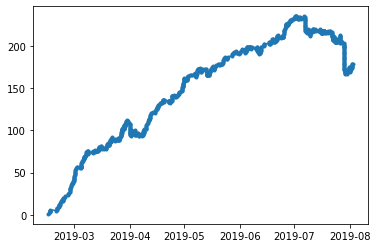

In [222]:
from matplotlib import pylab 
pylab.plot(untriaged.index, untriaged.values, '.-')

In [229]:
untriaged

2019-02-15 00:10:37      1
2019-02-15 11:44:19      2
2019-02-15 19:08:13      3
2019-02-15 20:57:10      4
2019-02-15 21:30:48      5
                      ... 
2019-08-01 21:03:36    176
2019-08-01 21:28:25    177
2019-08-01 22:57:28    178
2019-08-02 02:22:55    179
2019-08-02 12:57:45    178
Length: 1206, dtype: int64

## Update Needs Triage Kanban board 

* Update the [Kanban board](https://github.com/orgs/kubeflow/projects/26) tracking 

In [227]:
importlib.reload(triage)
triager=triage.IssueTriage()

In [228]:
repo="kubeflow/kubeflow"

today = datetime.datetime.now()
today = datetime.datetime(year=today.year, month=today.month, day=today.day)

start_time = today - datetime.timedelta(weeks=24)

issue_filter = {
    "since": start_time.isoformat(),
}
triager.triage(repo, issue_filter=issue_filter)

## Fetch Card Id

* This is a snipped which is useful for getting the id of a project card.
* We use it to fetch the card id that triage.py should add issues needing triage to.

In [24]:
project_query="""query projectCards($org: String!, $project: String!) {
  organization(login: $org) {
    projects(last: 1, search: $project) {
      totalCount
      edges {
        node {
          name
          url
          columns(first: 20) {
            totalCount
            pageInfo {
              endCursor
              hasNextPage
            }
            nodes {
              name
              id
            }
          }
        }
      }
    }
  }
}

"""
variables = {
    "org": "kubeflow",
    "project": "Bug Triage",
}
results = client.run_query(project_query, variables)
results

{'data': {'organization': {'projects': {'totalCount': 1,
    'edges': [{'node': {'name': 'Bug Triage',
       'url': 'https://github.com/orgs/kubeflow/projects/26',
       'columns': {'totalCount': 4,
        'pageInfo': {'endCursor': 'Y3Vyc29yOnYyOpIDzgBajOw=',
         'hasNextPage': False},
        'nodes': [{'name': 'Needs triage',
          'id': 'MDEzOlByb2plY3RDb2x1bW41OTM0MzEz'},
         {'name': 'High priority', 'id': 'MDEzOlByb2plY3RDb2x1bW41OTM0MzE0'},
         {'name': 'Low priority', 'id': 'MDEzOlByb2plY3RDb2x1bW41OTM0MzE1'},
         {'name': 'Closed', 'id': 'MDEzOlByb2plY3RDb2x1bW41OTM0MzE2'}]}}}]}}}}